In [1]:
import trainer
from utils import get_batch_classifier, slanted_triangular_learning_rate
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

In [2]:
with open('IntentDetection/word2idx.json', 'r') as inp:
    word2idx = json.load(inp)
with open('IntentDetection/char2idx.json', 'r') as inp:
    char2idx = json.load(inp)

In [3]:
VERSION = 'intent_102'
params = dict(
    model_configs = {
      "rnn_layers":[
          {
             "units": 1024,
             "drop_i": 0.2,
             "wdrop": 0.4,
             "drop_o": 0.2
          },
          {
             "units": 1024,
             "wdrop": 0.4,
             "drop_o": 0.2
          },
          {
             "units": 1024,
             "drop_o": 0.2,
             "wdrop": 0.4
          }
],
       "vocab_size": len(word2idx) + 1,
       "drop_e": 0.0,
       "char_vocab_size": len(char2idx) + 1,
       "char_cnn_options": {
           "layers": [
                [1, 16],
                [2, 16],
                [3, 32],
                [4, 64],
                [5, 128],
                [6, 256],
                [7, 512]
           ],
           "n_highways": 2
       },
       "char_vec_size": 16,
       "projection_dims": 512,
       "skip_connection": True
    },
    optimizer = tf.train.AdamOptimizer,
    negative_samples = 10240,
    wdecay = 1.2e-6,
    alpha = 1e-6,
    beta = 1e-6,
    clip_norm = 0.3,
    clip_min = -100.0, clip_max = 100.0,
    bptt = 70,
    use_ema = False,
    save_freq = 50,
    log_path = '{}/logs'.format(VERSION),
    train_summary_dir = '{}/train_summary/'.format(VERSION),
    test_summary_dir = '{}/test_summary/'.format(VERSION),
    checkpoint_dir = '{}/checkpoints/'.format(VERSION)
)

my_trainer = trainer.Trainer(**params, fine_tune=True)

my_trainer.logger.info('Trainer params {}'.format(params))

tf.reset_default_graph()

Trainer params {'model_configs': {'rnn_layers': [{'units': 1024, 'drop_i': 0.2, 'wdrop': 0.4, 'drop_o': 0.2}, {'units': 1024, 'wdrop': 0.4, 'drop_o': 0.2}, {'units': 1024, 'drop_o': 0.2, 'wdrop': 0.4}], 'vocab_size': 157876, 'drop_e': 0.0, 'char_vocab_size': 1415, 'char_cnn_options': {'layers': [[1, 16], [2, 16], [3, 32], [4, 64], [5, 128], [6, 256], [7, 512]], 'n_highways': 2}, 'char_vec_size': 16, 'projection_dims': 512, 'skip_connection': True}, 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'negative_samples': 10240, 'wdecay': 1.2e-06, 'alpha': 1e-06, 'beta': 1e-06, 'clip_norm': 0.3, 'clip_min': -100.0, 'clip_max': 100.0, 'bptt': 70, 'use_ema': False, 'save_freq': 50, 'log_path': 'intent_102/logs', 'train_summary_dir': 'intent_102/train_summary/', 'test_summary_dir': 'intent_102/test_summary/', 'checkpoint_dir': 'intent_102/checkpoints/'}


In [4]:
classifier_configs = {
    'layers': [
        {'batch_norm': False, 'drop_out': 0.2},
        {'units': 50, 'batch_norm': False, 'drop_out': 0.1, 'activation': 'relu'}
    ], 'n_classes': 2
}
my_trainer.build_classifier(classifier_configs, folder_name='classifier_interest_train')

/root/anaconda2/envs/tfp/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
my_trainer.restore_language_model('intent_102/checkpoints/test_intent/model.cpkt-11821')

INFO:tensorflow:Restoring parameters from intent_102/checkpoints/test_intent/model.cpkt-11821


Restoring parameters from intent_102/checkpoints/test_intent/model.cpkt-11821


In [6]:
class_chars = np.load('IntentDetection/class_chars.npy')
class_labels = pd.read_csv('IntentDetection/class_label.csv')

In [7]:
positive = class_chars[class_labels['interest']==1]
negative = class_chars[class_labels['interest']==0]

In [9]:
train_chars = np.concatenate([positive[:50], negative[:50]], axis=0)
train_labels = np.array([1]*50+[0]*50)
test_chars = np.concatenate([positive[50:], negative[50:]], axis=0)
test_labels = np.array([1]*len(positive[50:])+[0]*len(negative[50:]))

In [10]:
TRAIN_FOLDER = 'classifier_interest_train'
TEST_FOLDER = 'classifier_interest_test'
RATIO = 1/2.6
RATIO1 = RATIO/(1+RATIO)

In [13]:
log_lrs, losses = my_trainer.find_lr_classifier(train_chars, train_labels, 10, 48, [0, 50, 200], fine_tune_rate=[RATIO,0,0,0])

Batch    1,  lr 0.00000
Batch    2,  lr 0.00000
Batch    3,  lr 0.00000
Batch    4,  lr 0.00001
Batch    5,  lr 0.00004
Batch    6,  lr 0.00032
Batch    7,  lr 0.00251
Batch    8,  lr 0.01995
Batch    9,  lr 0.15849
INFO:tensorflow:Restoring parameters from intent_102/checkpoints/tmp/model.cpkt


Restoring parameters from intent_102/checkpoints/tmp/model.cpkt


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


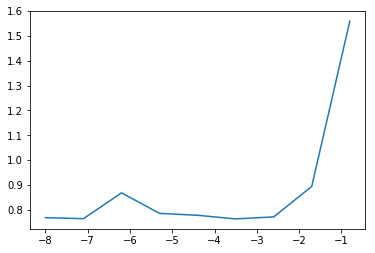

In [14]:
fig = plt.figure()
ax = plt.axes()
ax.plot(log_lrs, losses)

In [ ]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 6, 3e-4, 20, [0, 50, 200], fine_tune_rate=[0, 0, 0, 0], folder_name=TRAIN_FOLDER)

In [ ]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 10, 3e-4, 20, [0, 50, 200], fine_tune_rate=[RATIO, 0, 0, 0], folder_name=TRAIN_FOLDER)

In [ ]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 10, 3e-4, 20, [0, 50, 200], fine_tune_rate=[RATIO, RATIO*RATIO, 0, 0], folder_name=TRAIN_FOLDER)

In [ ]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 10, 3e-4, 20, [0, 50, 200], fine_tune_rate=[RATIO, RATIO*RATIO, RATIO*RATIO*RATIO, 0], folder_name=TRAIN_FOLDER)

In [ ]:
# for _ in range(10):
# my_trainer.train_step_classifier(train_chars, train_labels, 6, 3e-4, 20, [0, 50, 200], fine_tune_rate=[1/2.6, 1/2.6, 1/2.6, 1/2.6], folder_name='class_train_180')

In [15]:
NUM_EPOCH = 15
BATCH_SIZE = 10
TOTAL_ITER = NUM_EPOCH * len(train_labels)/BATCH_SIZE
LR_MAX = 3e-4
LR_RATIO = 32

In [16]:
lr = slanted_triangular_learning_rate(TOTAL_ITER, 1/NUM_EPOCH, LR_MAX, LR_RATIO)
for _ in range(NUM_EPOCH):
    my_trainer.train_step_classifier(train_chars, train_labels, BATCH_SIZE, lr, 48, [0, 50, 200], fine_tune_rate=[RATIO, RATIO1, RATIO1, RATIO], folder_name=TRAIN_FOLDER)
#     lr = max(lr * 0.4, 1e-5)

Step    1: loss: 1.00757, acc: 0.30000, bptt:  50, time 03.67
Step    2: loss: 0.77753, acc: 0.40000, bptt:  49, time 03.77
Step    3: loss: 0.77902, acc: 0.30000, bptt:  40, time 03.89
Step    4: loss: 0.75029, acc: 0.30000, bptt:  45, time 04.03
Step    5: loss: 0.85562, acc: 0.50000, bptt:  50, time 04.15
Step    6: loss: 0.60214, acc: 0.60000, bptt:  46, time 04.27
Step    7: loss: 0.66911, acc: 0.50000, bptt:  49, time 04.40
Step    8: loss: 0.53865, acc: 0.80000, bptt:  44, time 04.61
Step    9: loss: 0.77376, acc: 0.30000, bptt:  46, time 04.73
Step   10: loss: 0.44881, acc: 1.00000, bptt:  43, time 04.91
Step   11: loss: 0.31635, acc: 1.00000, bptt:  50, time 00.20
Step   12: loss: 0.30838, acc: 0.90000, bptt:  51, time 00.35
Step   13: loss: 0.36235, acc: 0.80000, bptt:  39, time 00.58
Step   14: loss: 0.32688, acc: 0.90000, bptt:  46, time 00.71
Step   15: loss: 0.23976, acc: 1.00000, bptt:  57, time 00.81
Step   16: loss: 0.10217, acc: 1.00000, bptt:  50, time 00.93
Step   1

Ignoring: intent_102/checkpoints/tmp; No such file or directory
Step   21: loss: 0.14263, acc: 1.00000, bptt:  51, time 00.26
Step   22: loss: 0.03967, acc: 1.00000, bptt:  47, time 00.38
Step   23: loss: 0.12863, acc: 0.90000, bptt:  56, time 00.48
Step   24: loss: 0.03078, acc: 1.00000, bptt:  47, time 00.61
Step   25: loss: 0.06209, acc: 1.00000, bptt:  43, time 00.71
Step   26: loss: 0.09347, acc: 1.00000, bptt:  50, time 00.84
Step   27: loss: 0.02708, acc: 1.00000, bptt:  40, time 01.07
Step   28: loss: 0.17788, acc: 0.90000, bptt:  49, time 01.19
Step   29: loss: 0.05708, acc: 1.00000, bptt:  21, time 01.44
Step   30: loss: 0.01265, acc: 1.00000, bptt:  44, time 01.56
Step   31: loss: 0.00726, acc: 1.00000, bptt:  41, time 00.27
Step   32: loss: 0.00653, acc: 1.00000, bptt:  48, time 00.39
Step   33: loss: 0.00234, acc: 1.00000, bptt:  45, time 00.48
Step   34: loss: 0.00045, acc: 1.00000, bptt:  47, time 00.59
Step   35: loss: 0.00145, acc: 1.00000, bptt:  45, time 00.73
Step  

In [ ]:
# for _ in range(10):
#     my_trainer.train_step_classifier(train_chars, train_labels, 12, lr, 20, [0, 50, 200], fine_tune_rate=[1.0, 1.0, 1.0, 1.0], folder_name=TRAIN_FOLDER)
#     lr = max(lr * 0.4, 1e-5)

In [17]:
from sklearn.metrics import classification_report

In [18]:
def eval_step_classifier(self, test_char, test_labels, batch_size, bptt, splits, folder_name='class_test'):
    import time
    import os
    start_time = time.time()
    save_path = os.path.join(self.checkpoint_dir, folder_name, 'model.cpkt')
    self.test_saver.save(self.session, save_path, global_step=self.session.run(self.global_step))
    total_loss = 0
    total_acc = 0
    count = 0
    predicts = []
    y_true = []
    for char_inputs, seq_lens, char_lens, true_labels in get_batch_classifier(test_char, test_labels, batch_size, splits, is_training=False):
        fd = {
            self.model_test.inputs: char_inputs, self.model_test.seq_lens: seq_lens,
            self.model_test.char_lens: char_lens, self.model_test.bptt: bptt,
            self.true_y: true_labels
        }
        y_pred, test_loss, test_acc = self.session.run([self.test_classifier.logits, self.test_loss, self.test_acc], feed_dict=fd)
        total_loss += test_loss * len(true_labels)
        total_acc += test_acc * len(true_labels)
        count += len(true_labels)
        predicts.append(y_pred)
        y_true.append(true_labels)
        print("Evaluate total loss: {:05.5f}, total acc: {:05.5f}, time {:05.2f}".format(total_loss/count, total_acc/count, time.time()-start_time))
    print(count)
    print(total_acc)
    return np.argmax(np.concatenate(predicts), axis=-1), np.concatenate(y_true)

In [19]:
y_pred, y_true = eval_step_classifier(my_trainer, test_chars, test_labels, 10, 20, [0, 50, 200], TEST_FOLDER)

Evaluate total loss: 3.96619, total acc: 0.10000, time 01.87
Evaluate total loss: 3.63030, total acc: 0.05000, time 02.91
Evaluate total loss: 3.16634, total acc: 0.13333, time 04.37
Evaluate total loss: 2.90907, total acc: 0.27500, time 04.51
Evaluate total loss: 3.02065, total acc: 0.28000, time 04.72
Evaluate total loss: 3.28262, total acc: 0.28333, time 04.83
Evaluate total loss: 3.53698, total acc: 0.30000, time 05.07
Evaluate total loss: 3.82086, total acc: 0.26250, time 05.18
Evaluate total loss: 4.09723, total acc: 0.26667, time 05.41
Evaluate total loss: 4.01179, total acc: 0.28000, time 05.58
Evaluate total loss: 3.76424, total acc: 0.32727, time 05.64
Evaluate total loss: 3.74465, total acc: 0.35000, time 05.69
Evaluate total loss: 3.53540, total acc: 0.38462, time 05.75
Evaluate total loss: 3.49101, total acc: 0.40000, time 05.83
Evaluate total loss: 3.28989, total acc: 0.43333, time 05.89
Evaluate total loss: 3.08578, total acc: 0.46875, time 05.94
Evaluate total loss: 3.0

Evaluate total loss: 1.61395, total acc: 0.67500, time 11.59
Evaluate total loss: 1.60335, total acc: 0.67664, time 11.64
Evaluate total loss: 1.60161, total acc: 0.67754, time 11.67
Evaluate total loss: 1.59453, total acc: 0.67914, time 11.70
Evaluate total loss: 1.59437, total acc: 0.67929, time 11.77
Evaluate total loss: 1.58763, total acc: 0.67943, time 11.81
Evaluate total loss: 1.58268, total acc: 0.67887, time 11.84
Evaluate total loss: 1.58215, total acc: 0.67832, time 11.89
Evaluate total loss: 1.57145, total acc: 0.68056, time 11.92
Evaluate total loss: 1.57655, total acc: 0.67793, time 11.97
Evaluate total loss: 1.56943, total acc: 0.67945, time 12.05
Evaluate total loss: 1.56576, total acc: 0.68095, time 12.10
Evaluate total loss: 1.56952, total acc: 0.67973, time 12.16
Evaluate total loss: 1.56579, total acc: 0.68121, time 12.20
Evaluate total loss: 1.56269, total acc: 0.68200, time 12.22
Evaluate total loss: 1.56468, total acc: 0.68146, time 12.26
Evaluate total loss: 1.5

Evaluate total loss: 1.54944, total acc: 0.68400, time 17.36
Evaluate total loss: 1.54538, total acc: 0.68478, time 17.40
Evaluate total loss: 1.53989, total acc: 0.68592, time 17.44
Evaluate total loss: 1.53833, total acc: 0.68633, time 17.48
Evaluate total loss: 1.53309, total acc: 0.68746, time 17.53
Evaluate total loss: 1.54051, total acc: 0.68571, time 17.58
Evaluate total loss: 1.55033, total acc: 0.68470, time 17.62
Evaluate total loss: 1.55750, total acc: 0.68333, time 17.66
Evaluate total loss: 1.57087, total acc: 0.68198, time 17.69
Evaluate total loss: 1.57887, total acc: 0.68063, time 17.74
Evaluate total loss: 1.58212, total acc: 0.68000, time 17.77
Evaluate total loss: 1.58806, total acc: 0.67937, time 17.80
Evaluate total loss: 1.59763, total acc: 0.67840, time 17.84
Evaluate total loss: 1.60442, total acc: 0.67743, time 17.87
Evaluate total loss: 1.61434, total acc: 0.67612, time 17.91
Evaluate total loss: 1.62100, total acc: 0.67517, time 17.94
Evaluate total loss: 1.6

Evaluate total loss: 1.67878, total acc: 0.66496, time 22.86
Evaluate total loss: 1.67542, total acc: 0.66529, time 22.91
Evaluate total loss: 1.67511, total acc: 0.66465, time 22.96
Evaluate total loss: 1.68379, total acc: 0.66401, time 23.00
Evaluate total loss: 1.68448, total acc: 0.66361, time 23.07
Evaluate total loss: 1.68612, total acc: 0.66346, time 23.13
Evaluate total loss: 1.68898, total acc: 0.66283, time 23.16
Evaluate total loss: 1.68972, total acc: 0.66268, time 23.20
Evaluate total loss: 1.69376, total acc: 0.66181, time 23.24
Evaluate total loss: 1.69699, total acc: 0.66143, time 23.29
Evaluate total loss: 1.69941, total acc: 0.66105, time 23.33
Evaluate total loss: 1.69784, total acc: 0.66114, time 23.36
Evaluate total loss: 1.70420, total acc: 0.66028, time 23.40
Evaluate total loss: 1.70348, total acc: 0.65991, time 23.44
Evaluate total loss: 1.70726, total acc: 0.65929, time 23.49
Evaluate total loss: 1.70867, total acc: 0.65845, time 23.52
Evaluate total loss: 1.7

Evaluate total loss: 1.75261, total acc: 0.64772, time 28.64
Evaluate total loss: 1.75452, total acc: 0.64727, time 28.71
Evaluate total loss: 1.75599, total acc: 0.64664, time 28.76
Evaluate total loss: 1.75651, total acc: 0.64656, time 28.81
Evaluate total loss: 1.75386, total acc: 0.64702, time 28.85
Evaluate total loss: 1.75073, total acc: 0.64765, time 28.88
Evaluate total loss: 1.75300, total acc: 0.64739, time 28.95
Evaluate total loss: 1.75037, total acc: 0.64766, time 28.97
Evaluate total loss: 1.74787, total acc: 0.64811, time 29.03
Evaluate total loss: 1.74969, total acc: 0.64767, time 29.09
Evaluate total loss: 1.74910, total acc: 0.64776, time 29.14
Evaluate total loss: 1.75070, total acc: 0.64696, time 29.22
Evaluate total loss: 1.75604, total acc: 0.64635, time 29.28
Evaluate total loss: 1.75768, total acc: 0.64573, time 29.34
Evaluate total loss: 1.75909, total acc: 0.64565, time 29.40
Evaluate total loss: 1.76113, total acc: 0.64504, time 29.45
Evaluate total loss: 1.7

In [20]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.95      0.64      0.76      5305
           1       0.21      0.74      0.32       676

   micro avg       0.65      0.65      0.65      5981
   macro avg       0.58      0.69      0.54      5981
weighted avg       0.87      0.65      0.71      5981

